In [32]:
import os
import numpy
import glob
from shutil import copyfile
from time import time
import numpy as np

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

In [33]:
base_dir = '/Users/nalingupta/Documents/Documents /NEU/DS5500 Capstone Project/Project/Test Videos'

In [60]:
def get_frames(frames_dir):
    imgs = []
    frames = sorted(glob.glob(frames_dir))
    
    for img in frames:
        image = load_img(img, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        imgs.append(image)
    
    return frames, np.array(imgs)

In [61]:
frames, imgs = get_frames(os.path.join(base_dir, 'shots', '*.png'))

In [62]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

feature_map = model.predict(imgs)

In [63]:
perplexities = [i for i in range(5, 55, 5)]
perplexities

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

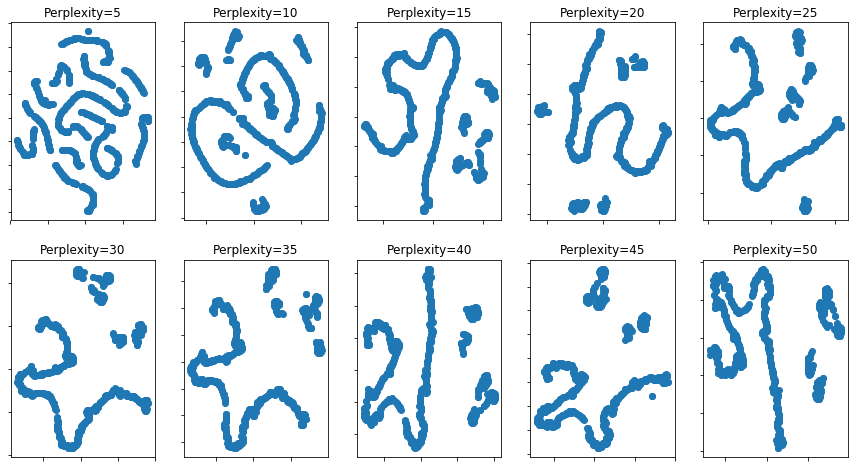

In [64]:
(fig, subplots) = plt.subplots(2, 5, figsize=(15, 8))

for (i, perplexity), ax in zip(enumerate(perplexities), fig.axes):
    tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(feature_map)
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter([item[0] for item in Y], [item[1] for item in Y])
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

In [65]:
tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=50)
X = tsne.fit_transform(feature_map)

In [66]:
db = DBSCAN(eps=7, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 0


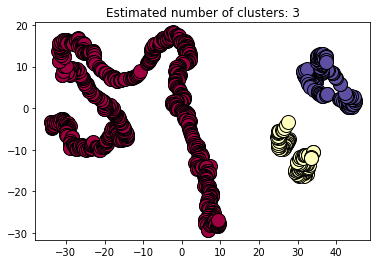

In [67]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [59]:
results_folder = os.path.join(base_dir, 'segmentation_results', 'longer_segmentation')
for label, img in zip(db.labels_, frames):
    result_dir = os.path.join(results_folder, str(label))
    result_dest = os.path.join(results_folder, str(label), os.path.split(img)[1])
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    copyfile(img, result_dest)